# 1) Preparation

## Imports

In [53]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch, resample
from scipy.stats import mode

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Load raw data

In [54]:
ninapro_path = 'data/DB3/'
npulse_path = 'data/pers_data/'

In [55]:
# Load all Ninapro data from folder "DB3"
data_ninapro = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")

# Load all personal data from folder "pers_data"
data_npulse = pd.read_csv("data/pers_data/raw/WS_R_4_250328161002.csv")


## Data preparation : functions

In [56]:
# Action1 + Action2 -> Gesture
def compute_flat_label(row):
    if pd.isna(row['Action2']): # if Action2 is NaN, return Action1
        return row['Action1']
    elif ((row['Action1'] == 'Rest') and (not pd.isna(row['Action2']))): # if Action1 is Rest and Action2 is not NaN, return Action1
        return row['Action2']
    elif ((row['Action2'] == 'Rest') and (not pd.isna(row['Action1']))): # if Action2 is Rest and Action1 is not NaN, return Action2
        return row['Action1']
    else:
        print("Error")
        return row['Action1']

In [57]:
# Downsample dataframe
def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan  # Handle empty mode
            )
            grouped = grouped.fillna(method='ffill')  # Forward-fill NaN values
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds

In [58]:
id_to_gesture = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

npulse_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in id_to_gesture.items() if v in npulse_gestures}

In [59]:
def hampel_filter(series, window_size=3, n_sigmas=3):
    """Applies Hampel filter to a 1D pandas Series."""
    L = 1.4826  # scale factor for Gaussian distribution
    rolling_median = series.rolling(window=2 * window_size + 1, center=True).median()
    diff = np.abs(series - rolling_median)
    mad = L * diff.rolling(window=2 * window_size + 1, center=True).median()
    
    # Identify outliers
    outlier_idx = diff > n_sigmas * mad
    filtered = series.copy()
    filtered[outlier_idx] = rolling_median[outlier_idx]
    return filtered

In [60]:
def clean_data(raw_data):
    cleaned_data = raw_data.copy()
    
    # Remove the first row
    cleaned_data = cleaned_data.drop(index=0)

    # Number of channels
    num_channels = 2

    # Compute the average sampling frequency and jitter
    sampling_freq = 1 / np.mean(np.diff(cleaned_data["Timestamp"]))
    jitter = np.mean(np.diff(cleaned_data["Timestamp"]))
    print(f"Sampling Frequency: {sampling_freq} Hz")
    print(f"Jitter: {jitter} seconds")

    for i in range(num_channels): # nb of channels
        channel = cleaned_data["Channel{}".format(i+1)]

        # Remove DC offset
        channel = (channel - np.mean(channel))

        # Filter 50Hz noise using a Hampel filter
        channel = hampel_filter(channel)

        cleaned_data["Channel{}".format(i+1)] = channel
    
    return cleaned_data

## Data cleaning

### Ninapro

In [61]:
# Useful information about dataset
emg_rectified = data_ninapro["emg"]
stimulus = data_ninapro["stimulus"] 
repetition = data_ninapro["repetition"] 
restimulus = data_ninapro['restimulus']
rerepetition = data_ninapro['rerepetition']

n_stimuli = len(np.unique(restimulus)) - 1
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

In [62]:
# Create dataframe + add Timestamp column
data_ninapro_df = pd.DataFrame()

for channel in range(n_channels):
    data_ninapro_df[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
    # data_ninapro_df['Stimulus'] = stimulus.flatten()
    # data_ninapro_df['Repetition'] = repetition.flatten()
    data_ninapro_df['Restimulus'] = restimulus.flatten()
    data_ninapro_df['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (Ninapro sampling rate)
n_samples = data_ninapro_df.shape[0]

data_ninapro_df['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column

In [63]:
# Delete unused columns
data_ninapro_df.drop(columns=['Channel1', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel9', 'Channel10', 'Channel11', 'Channel12'], inplace=True)

# Keep selected stimuli (N-pulse stimuli)
data_ninapro_df = data_ninapro_df[data_ninapro_df['Restimulus'].isin(gesture_to_id.values())]

In [64]:
# Downsample
data_ninapro_downsampled = downsample_dataframe_with_labels(data_ninapro_df, target_freq=1000, time_col='Timestamp', label_cols=['Restimulus', 'Rerepetition'], method='resample')

In [145]:
# Rename columns and convert to int
data_ninapro_downsampled.rename(columns={'Restimulus': 'Gesture', 'Rerepetition': 'Repetition'}, inplace=True)
data_ninapro_downsampled['Gesture'] = data_ninapro_downsampled['Gesture'].astype(int)
data_ninapro_downsampled['Repetition'] = data_ninapro_downsampled['Repetition'].astype(int)

### N-pulse

In [67]:
# Filter data
data_npulse_filtered = clean_data(data_npulse)

Sampling Frequency: 1461.9821283509343 Hz
Jitter: 0.0006840028893704506 seconds


In [68]:
# Gesture column
data_npulse_copy = data_npulse.copy()
data_npulse_copy.drop(index=0, inplace=True)
data_npulse_copy['Gesture'] = data_npulse_copy.apply(compute_flat_label, axis=1)
data_npulse_copy['Gesture'] = data_npulse_copy['Gesture'].map(gesture_to_id)
data_npulse_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [69]:
# Downsample
data_npulse_downsampled = downsample_dataframe_with_labels(data_npulse_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')


In [144]:
# Changing Gesture column to int
data_npulse_downsampled['Gesture'] = data_npulse_downsampled['Gesture'].astype(int)

In [70]:
# SNR normalization
rest_ninapro_channel2 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 0]['Channel2']
rest_ninapro_channel8 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 0]['Channel8']

rest_npulse_channel1 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 0]['Channel1']
rest_npulse_channel2 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 0]['Channel2']

scaling_factor_channel1 = np.sqrt(np.mean(rest_ninapro_channel2**2) / np.mean(rest_npulse_channel1**2))
scaling_factor_channel2 = np.sqrt(np.mean(rest_ninapro_channel8**2) / np.mean(rest_npulse_channel2**2))

data_npulse_downsampled['Channel1'] *= scaling_factor_channel1
data_npulse_downsampled['Channel2'] *= scaling_factor_channel2

## Save data

In [148]:
cleaned_ninapro_path = "data/cleaned/NINAPRO/"
cleaned_npulse_path = "data/cleaned/NPULSE/"

os.makedirs(cleaned_ninapro_path, exist_ok=True)
os.makedirs(cleaned_npulse_path, exist_ok=True)

data_ninapro_downsampled.to_csv(cleaned_ninapro_path + "cleaned_ninapro_df.csv", index=False)
data_npulse_downsampled.to_csv(cleaned_npulse_path + "cleaned_npulse_df.csv", index=False)

# 1.5) Verification

## Checking dataframe columns

In [149]:
data_ninapro_downsampled.head(10)

,Timestamp,Channel2,Channel8,Gesture,Repetition
0,0.000,-2.285929e-07,-0.000004,0,1
1,0.001,-1.780012e-06,-0.000004,0,1
2,0.002,-4.696690e-06,-0.000004,0,1
3,0.003,-2.146219e-06,-0.000003,0,1
4,0.004,1.890764e-06,-0.000003,0,1
5,0.005,2.021670e-06,-0.000004,0,1
6,0.006,2.087339e-06,-0.000006,0,1
7,0.007,3.130160e-06,-0.000006,0,1
8,0.008,3.534605e-06,-0.000004,0,1
9,0.009,2.239357e-06,-0.000003,0,1


In [150]:
data_npulse_downsampled.head(10)

,Timestamp,Channel1,Channel2,Gesture
0,0.161,0.000017,0.000024,0
1,0.162,0.000017,0.000024,0
2,0.163,0.000017,0.000024,0
3,0.164,0.000017,0.000023,0
4,0.165,0.000017,0.000023,0
5,0.166,0.000017,0.000023,0
6,0.167,0.000017,0.000023,0
7,0.168,0.000017,0.000023,0
8,0.169,0.000017,0.000023,0
9,0.170,0.000017,0.000023,0


In [151]:
# Count NaN values in each column
print("Ninapro Data NaN Count:")
print(data_ninapro_downsampled.isna().sum())

print("\nNpulse Data NaN Count:")
print(data_npulse_downsampled.isna().sum())


Ninapro Data NaN Count:
Timestamp     0
Channel2      0
Channel8      0
Gesture       0
Repetition    0
dtype: int64

Npulse Data NaN Count:
Timestamp    0
Channel1     0
Channel2     0
Gesture      0
dtype: int64


In [152]:
# Check the length of the dataframes
print(f"Ninapro Data Length: {len(data_ninapro_downsampled)}")
print(f"Npulse Data Length: {len(data_npulse_downsampled)}")

Ninapro Data Length: 912503
Npulse Data Length: 49240


## Samples for each gesture

In [153]:
for gesture in npulse_gestures:
    print(f"Gesture: {gesture}")
    id = gesture_to_id[gesture]
    ninapro_gesture = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == id]
    npulse_gesture = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == id]

    print(f"Ninapro Data Length: {len(ninapro_gesture)}")
    print(f"Npulse Data Length: {len(npulse_gesture)}")

Gesture: Fist
Ninapro Data Length: 39087
Npulse Data Length: 5281
Gesture: WristExt
Ninapro Data Length: 39144
Npulse Data Length: 4753
Gesture: WristRotExt
Ninapro Data Length: 13600
Npulse Data Length: 5030
Gesture: Rest
Ninapro Data Length: 723343
Npulse Data Length: 19455
Gesture: Palm
Ninapro Data Length: 39040
Npulse Data Length: 4715
Gesture: WristFlexion
Ninapro Data Length: 19336
Npulse Data Length: 5169
Gesture: WristRotIn
Ninapro Data Length: 38953
Npulse Data Length: 4837


## Correspondance Ninapro and N-pulse

Ninapro Gesture 1 Channel 2 Length: 39087
Ninapro Gesture 1 Channel 8 Length: 39087
Npulse Gesture 1 Channel 1 Length: 5281
Npulse Gesture 1 Channel 2 Length: 5281


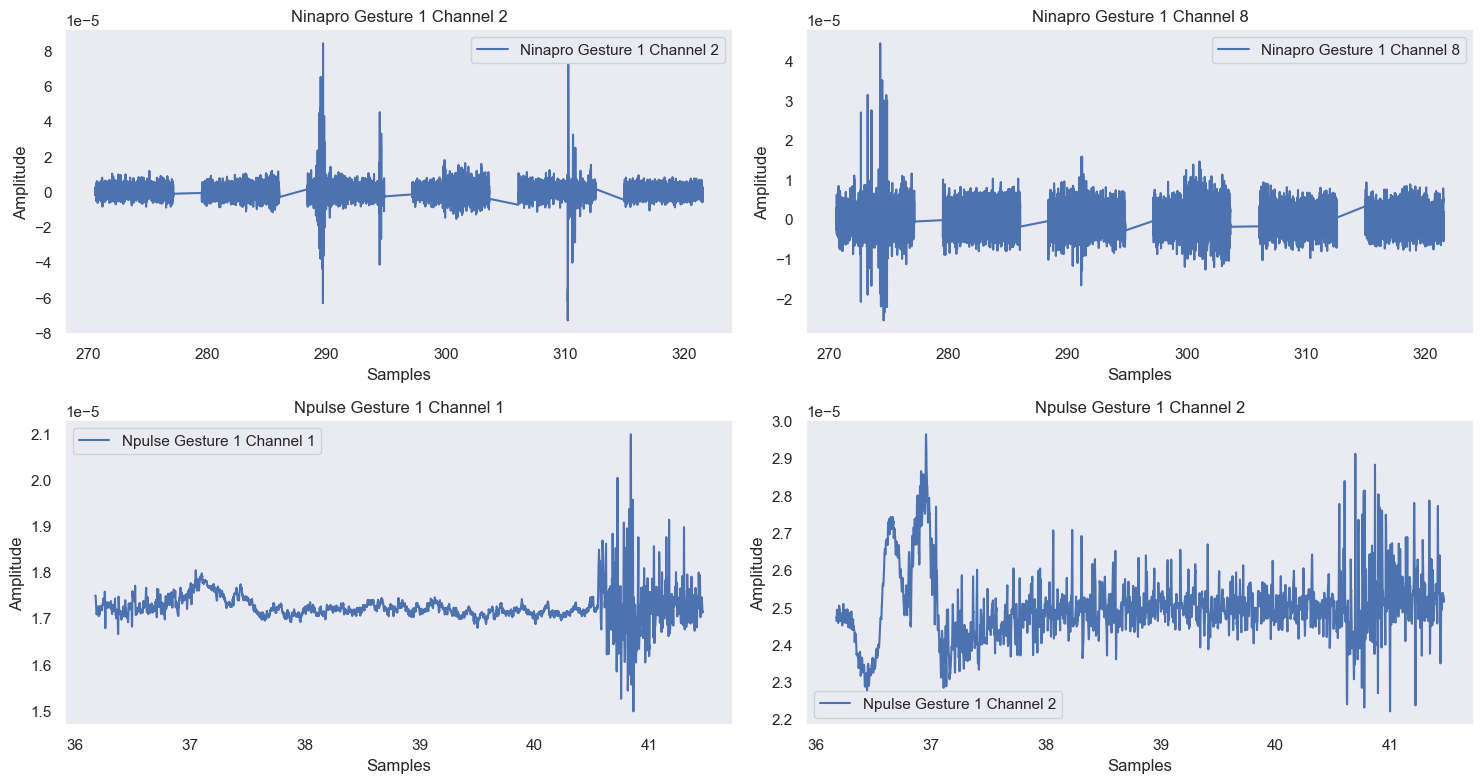

In [163]:
ninapro_gesture1 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 6]
npulse_gesture1 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 6]

print(f"Ninapro Gesture 1 Channel 2 Length: {len(ninapro_gesture1['Channel2'])}")
print(f"Ninapro Gesture 1 Channel 8 Length: {len(ninapro_gesture1['Channel8'])}")
print(f"Npulse Gesture 1 Channel 1 Length: {len(npulse_gesture1['Channel1'])}")
print(f"Npulse Gesture 1 Channel 2 Length: {len(npulse_gesture1['Channel2'])}")

# Plotting the signals
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(ninapro_gesture1['Timestamp'], ninapro_gesture1['Channel2'], label='Ninapro Gesture 1 Channel 2')
plt.title('Ninapro Gesture 1 Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(ninapro_gesture1['Timestamp'], ninapro_gesture1['Channel8'], label='Ninapro Gesture 1 Channel 8')
plt.title('Ninapro Gesture 1 Channel 8')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(npulse_gesture1['Timestamp'], npulse_gesture1['Channel1'], label='Npulse Gesture 1 Channel 1')
plt.title('Npulse Gesture 1 Channel 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(npulse_gesture1['Timestamp'], npulse_gesture1['Channel2'], label='Npulse Gesture 1 Channel 2')
plt.title('Npulse Gesture 1 Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 2) Model

## Load preprocessed data

In [74]:
cleaned_ninapro_path = "data/cleaned/NINAPRO/"
cleaned_npulse_path = "data/cleaned/NPULSE/"

training_data = pd.read_csv(cleaned_ninapro_path + "cleaned_ninapro_df.csv")
testing_data = pd.read_csv(cleaned_npulse_path + "cleaned_npulse_df.csv")

## Features

In [75]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Frequency domain features (FFT-based)
fft_values = lambda x: np.fft.fft(x, axis=0)
fft_magnitude = lambda x: np.abs(fft_values(x))
fft_power = lambda x: np.square(fft_magnitude(x))
freqs = lambda x: np.fft.fftfreq(x.shape[0], d=1/1000)  # Assuming a sampling rate of 1000 Hz

# Total power
total_power = lambda x: np.sum(fft_power(x), axis=0)  
# Mean frequency
mean_freq = lambda x: np.sum(freqs(x) * fft_power(x), axis=0) / np.sum(fft_power(x), axis=0) 
# Median frequency
median_freq = lambda x: np.median(freqs(x) * fft_power(x), axis=0) 
# Peak frequency 
peak_freq = lambda x: freqs(x)[np.argmax(fft_power(x), axis=0)]  

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

features_selected = [std, maxav, total_power, mean_freq, median_freq, peak_freq]

In [129]:
def extract_features_and_labels(data, features, window=200, step_size=50):
    X = data.copy()
    X.drop(columns=['Gesture', 'Timestamp'], inplace=True)
    if 'Repetition' in X.columns:
        X.drop(columns=['Repetition'], inplace=True)
    y = data['Gesture']
    
    features_list = []
    labels_list = []

    for i in range(0, len(data) - window + 1, step_size):
        window_data = data.iloc[i:i + window]

        feature_vector = [feature(window_data[channel].values) for channel in X.columns for feature in features]

        features_list.append(feature_vector)
        labels_list.append(window_data['Gesture'].values[0])
    
    return np.array(features_list), np.array(labels_list)

In [130]:
window = 200
step = 50

training_features, training_labels = extract_features_and_labels(data_ninapro_downsampled, features_selected, window=window, step_size=step)
testing_features, testing_labels = extract_features_and_labels(data_npulse_downsampled, features_selected, window=window, step_size=step)

## Training

In [133]:
# Define the Random Forest model
rf = RandomForestClassifier()

# Hyperparameter optimization using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'n_estimators': [100],
    # 'max_depth': [10],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [2],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(training_features, training_labels)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(training_features, training_labels)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(max_depth=30, min_samples_leaf=4)

# 3) Performance

Accuracy score: 0.3965341488277268
Recall score: 0.14285714285714285
F1 score: 0.08112617309697602


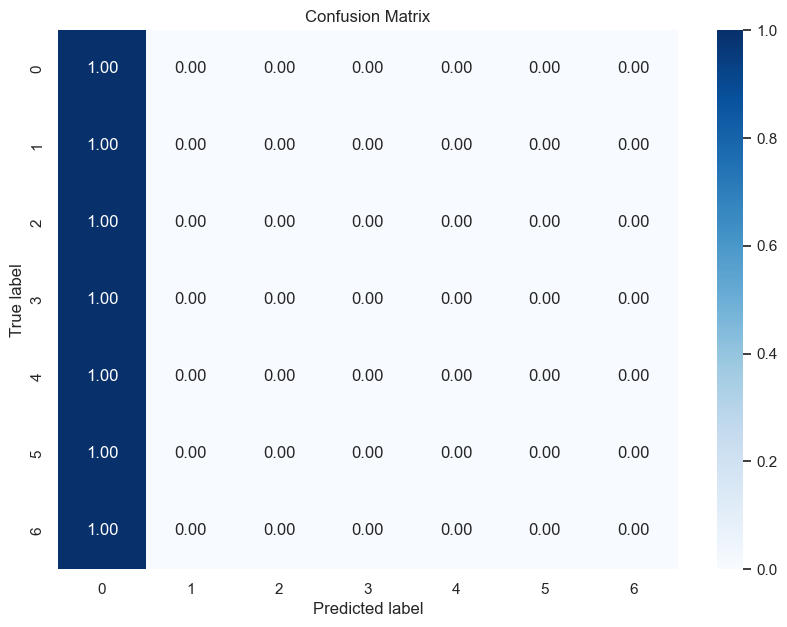

In [134]:
# Evaluate the model
y_pred = best_rf.predict(testing_features)
accuracy = accuracy_score(testing_labels, y_pred)
print(f"Accuracy score: {accuracy}")
print(f"Recall score: {recall_score(testing_labels, y_pred, average='macro')}")
print(f"F1 score: {f1_score(testing_labels, y_pred, average='macro')}")

# Confusion matrix
confmat = confusion_matrix(testing_labels, y_pred, normalize="true")
plt.figure(figsize=(10, 7))
sns.heatmap(confmat, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()